# Preprocessing and Training Data Development

Two things I want to explore: 
* Is there a **particle count** difference between locations with **CFU** measurements above below 10?
* Are particulate counts an indicator of CFU counts?

In [1]:
#importing the tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import featuretools as ft
import featuretools.variable_types as vtypes


from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split

In [2]:
file = 'data\combined_VAS.csv'
file2 = 'data\cfu.csv'
file3 = 'data\prtc.csv'

df = pd.read_csv(file,index_col=0,parse_dates=True)
cfu = pd.read_csv(file2,index_col=0,parse_dates=True)
prtc = pd.read_csv(file3,index_col=0,parse_dates=True)

df['Date'] = pd.to_datetime(df['Date'])
df['cfu'] = pd.to_numeric(df['cfu'])
df.reset_index()
df.dtypes,df.shape

(Date                      datetime64[ns]
 location                          object
 Temp                             float64
 RH                               float64
 Total_Particles>0.3              float64
 Total_Particles>0.5/m3           float64
 Traffic                           object
 Weather                           object
 cfu                              float64
 Source                            object
 dtype: object,
 (859, 10))

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 859 entries, 39 to 2089
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    859 non-null    datetime64[ns]
 1   location                859 non-null    object        
 2   Temp                    859 non-null    float64       
 3   RH                      859 non-null    float64       
 4   Total_Particles>0.3     859 non-null    float64       
 5   Total_Particles>0.5/m3  859 non-null    float64       
 6   Traffic                 857 non-null    object        
 7   Weather                 716 non-null    object        
 8   cfu                     859 non-null    float64       
 9   Source                  859 non-null    object        
dtypes: datetime64[ns](1), float64(5), object(4)
memory usage: 73.8+ KB


In [4]:
df = df.dropna(axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 39 to 2089
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    714 non-null    datetime64[ns]
 1   location                714 non-null    object        
 2   Temp                    714 non-null    float64       
 3   RH                      714 non-null    float64       
 4   Total_Particles>0.3     714 non-null    float64       
 5   Total_Particles>0.5/m3  714 non-null    float64       
 6   Traffic                 714 non-null    object        
 7   Weather                 714 non-null    object        
 8   cfu                     714 non-null    float64       
 9   Source                  714 non-null    object        
dtypes: datetime64[ns](1), float64(5), object(4)
memory usage: 61.4+ KB


In [5]:
df.cfu.value_counts()

0.0     254
1.0     162
2.0      69
34.0     59
3.0      35
4.0      21
6.0      14
5.0      13
7.0      12
14.0      7
10.0      6
11.0      6
13.0      6
8.0       5
23.0      5
12.0      4
17.0      4
9.0       4
16.0      3
24.0      3
30.0      3
20.0      3
26.0      2
28.0      2
15.0      2
22.0      2
25.0      2
18.0      2
33.0      1
21.0      1
29.0      1
31.0      1
Name: cfu, dtype: int64

In [6]:
df['threshold'] = np.where(df['cfu'] < 10, 'under','over') # establish 10CFU threshold
df = df[df['RH'] >10]
                # ^ removing <10. Relative humidity is the 
                # | percentage of water vapor in the air 
                #at a specific temperature; compared 
                #to the amount of water vapor the air
                #is capable of holding at that temperature.
df['sample_id'] = df['Date'].astype(str) + '/' + df['location'].astype(str).str.lower().str.replace(' ','-') #new index
df = df.set_index('sample_id')
dfo=df.select_dtypes(include=['object','category'])
df = pd.concat([df.drop(dfo, axis=1), pd.get_dummies(dfo)], axis=1) #adding dummies to df

In [7]:
X = df.drop(columns='cfu')
y = df.cfu
scaler_pt = PowerTransformer()
scaler = StandardScaler()

X['tp3_lg'] = scaler_pt.fit_transform(X[['Total_Particles>0.3']])
X['tp5m3_lg'] = scaler_pt.fit_transform(X[['Total_Particles>0.5/m3']])
X['temp_ss'] = scaler.fit_transform(X[['Temp']])
X['rh_ss'] = scaler.fit_transform(X[['RH']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [8]:
X_train.shape, X_train.describe()

((534, 103),
              Temp          RH  Total_Particles>0.3  Total_Particles>0.5/m3  \
 count  534.000000  534.000000         5.340000e+02            5.340000e+02   
 mean    71.435581   44.461236         4.509388e+04            1.330042e+06   
 std      3.563802    9.865844         1.141212e+05            3.158486e+06   
 min     38.900000   15.000000         2.540000e+02            4.950000e+02   
 25%     70.300000   38.000000         2.891000e+03            1.562722e+05   
 50%     72.100000   45.950000         1.380000e+04            4.216025e+05   
 75%     73.500000   50.800000         4.319150e+04            1.105037e+06   
 max     78.200000   76.900000         1.338270e+06            4.504894e+07   
 
        location_11L NS  location_11L SEC  \
 count       534.000000        534.000000   
 mean          0.022472          0.029963   
 std           0.148351          0.170644   
 min           0.000000          0.000000   
 25%           0.000000          0.000000   
 50%

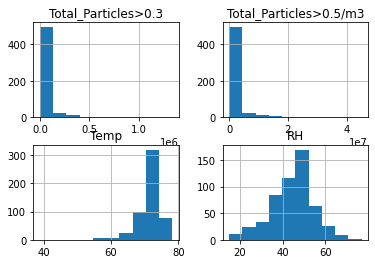

In [9]:
X_train[['Total_Particles>0.3','Total_Particles>0.5/m3','Temp','RH']].hist()
plt.show()

<AxesSubplot:>

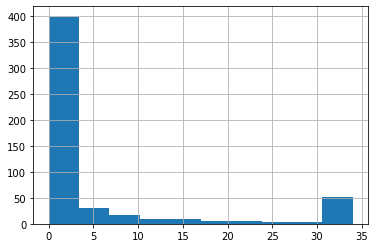

In [10]:
y_train.hist()

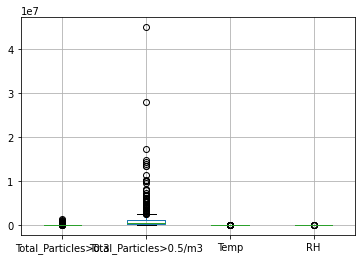

In [11]:
X_train[['Total_Particles>0.3','Total_Particles>0.5/m3','Temp','RH']].boxplot()
plt.show()

<AxesSubplot:>

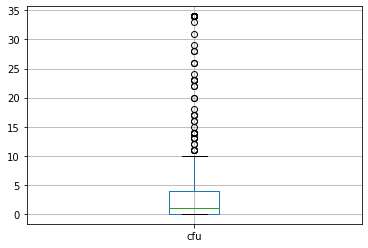

In [12]:
pd.DataFrame(y_train).boxplot()

#### The above graphs look non-normal except for RH, which is still a bit skewed. I will need to look at transformed data. 
#### The boxplots also show they need to be scaled.

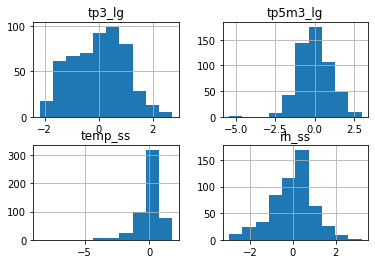

In [13]:
X_train[['tp3_lg','tp5m3_lg','temp_ss','rh_ss']].hist()
plt.show()

normalized and scaled. prt5 and temp_ss both have a large negative outlier.

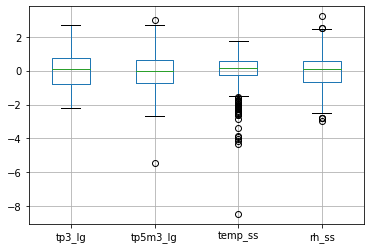

In [14]:
X_train[['tp3_lg','tp5m3_lg','temp_ss','rh_ss']].boxplot()
plt.show()

a lot of temperatires are far from the mean. pausible outlier in tpm5m3

In [15]:
X_train.loc[(X_train['tp5m3_lg']<-4) | (X_train['temp_ss']<-3)]

,Date,Temp,RH,Total_Particles>0.3,Total_Particles>0.5/m3,location_11L NS,location_11L SEC,location_350 Parnassus Suite 300 by reception area,location_350 Parnassus Suite 300 just outside containment,location_9L NS,...,Weather_Sunny,Source_MB,Source_ML,Source_adhoc,threshold_over,threshold_under,tp3_lg,tp5m3_lg,temp_ss,rh_ss
sample_id,,,,,,,,,,,,,,,,,,,,,
2015-04-24/mbh-shuttle-stop,2015-04-24,54.8,68.4,87333.0,4342231.0,0,0,0,0,0,...,0,0,0,1,1,0,1.144058,1.533396,-4.317821,2.361708
2017-12-22/ogt3-c5,2017-12-22,58.4,27.0,116161.0,3415194.0,0,0,0,0,0,...,0,1,0,0,1,0,1.308254,1.378368,-3.379725,-1.787527
2018-03-02/mbh-shuttle-stop,2018-03-02,56.0,44.0,68261.0,5763428.0,0,0,0,0,0,...,0,1,0,0,1,0,1.002392,1.714347,-4.005122,-0.083735
2018-02-22/ed-lot,2018-02-22,56.6,36.0,39368.0,2839223.0,0,0,0,0,0,...,0,0,1,0,1,0,0.686482,1.258157,-3.848773,-0.885519
2017-01-24/mbh-shuttle-stop,2017-01-24,55.4,56.3,1338270.0,13808348.0,0,0,0,0,0,...,0,1,0,0,1,0,2.723448,2.260481,-4.161472,1.149009
2015-11-23/bmt-c6924,2015-11-23,71.6,43.4,495.0,495.0,0,0,0,0,0,...,0,1,0,0,0,1,-1.797900,-5.446280,0.059959,-0.143869
2017-12-19/hallway-by-nursing-station-outside-plastic-barrier-14m,2017-12-19,56.4,46.0,602534.0,13514310.0,0,0,0,0,0,...,0,0,0,1,0,1,2.259770,2.247246,-3.900890,0.116711
2017-04-27/ogt4-c4,2017-04-27,38.9,40.0,80103.0,5400000.0,0,0,0,0,0,...,0,1,0,0,1,0,1.094355,1.672896,-8.461078,-0.484627


4 of these are outdoor locations, and 6 are above the cfu threshold. seems important. the 2015-11-23/bmt-c6924 sample has the same tp3 and tp5m3, which seems plausible if the air is clean enough as the total particulates above 0.3micron could equal the total particulates above 0.5microns per cubic meter.